**Data Wrangler:** Elijah Taber

**Data Scientist:** Caleb Trimble

**Data Visualizer/Presenter:** Michael Speer

<center><h1>Project 1 - Earthquakes</h1></center>

**Data Source:** https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv

## Earthquake Data Card

| Field | Description |
|-------|-------------|
| **time** | Timestamp of when the earthquake occurred in UTC format. |
| **latitude** | North-south geographic coordinate of the earthquake in decimal degrees. |
| **longitude** | East-west geographic coordinate of the earthquake in decimal degrees. |
| **depth** | Distance from the earth's surface to the hypocenter in kilometers. |
| **mag** | Magnitude of the earthquake, representing its size or energy release. |
| **magType** | Method or scale used to calculate the magnitude (ml = local magnitude, mb = body-wave magnitude, md = duration magnitude). |
| **nst** | Number of seismic stations that contributed to determining the earthquake location. |
| **gap** | Largest azimuthal gap between azimuthally adjacent stations in degrees. |
| **dmin** | Horizontal distance in degrees from the epicenter to the nearest station. |
| **rms** | Root mean square of travel time residuals in seconds, measuring the fit of observed arrival times to predicted arrival times. |
| **net** | ID of the network that contributed the most data used to locate the earthquake. |
| **id** | Unique identifier for the earthquake event. |
| **updated** | Timestamp of when the earthquake information was last revised. |
| **place** | Textual description of the geographic location of the earthquake. |
| **type** | Type of seismic event ('earthquake', 'explosion', 'quarry blast', 'ice quake', 'other event'). |
| **horizontalError** | Uncertainty of the reported location of the earthquake in kilometers. |
| **depthError** | Uncertainty of the reported depth of the earthquake in kilometers. |
| **magError** | Uncertainty of the reported magnitude of the earthquake. |
| **magNst** | Number of seismic stations that contributed to determining the earthquake magnitude. |
| **status** | Review status of the earthquake (automatic or reviewed by a human). |
| **locationSource** | Network that determined the earthquake location. |
| **magSource** | Network that determined the earthquake magnitude. |

**Target Variable:** mag

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

df = pd.read_csv('earthquakes.csv')
print(df.shape)
df.head()

(9790, 22)


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-03-28T01:59:29.748Z,37.154600,-117.414400,0.00,1.70,ml,12.0,129.5,0.16300,0.3882,nn,nn00895230,2025-03-28T02:06:35.591Z,"63 km SSW of Goldfield, Nevada",earthquake,NaN,7.700,0.340000,7.0,automatic,nn,nn
1,2025-03-28T01:57:36.250Z,35.536835,-120.836334,7.20,1.90,md,20.0,72.0,0.09811,0.0300,nc,nc75156462,2025-03-28T01:59:11.162Z,"12 km NE of Cayucos, CA",earthquake,0.30,0.890,0.140000,14.0,automatic,nc,nc
2,2025-03-28T01:53:57.153Z,-15.922100,167.894300,172.90,5.00,mb,48.0,142.0,0.81600,0.6500,us,us7000pn8t,2025-03-28T02:11:11.040Z,"54 km ENE of Lakatoro, Vanuatu",earthquake,10.15,5.454,0.067000,71.0,reviewed,us,us
3,2025-03-28T01:41:18.660Z,38.819000,-122.766670,1.66,1.45,md,12.0,106.0,0.01173,0.0200,nc,nc75156457,2025-03-28T01:42:56.113Z,"4 km W of Cobb, CA",earthquake,0.29,0.480,0.190000,14.0,automatic,nc,nc
4,2025-03-28T01:22:38.780Z,17.955333,-66.832167,13.71,2.17,md,7.0,208.0,0.04893,0.1100,pr,pr71477703,2025-03-28T01:32:39.220Z,"4 km SSW of Indios, Puerto Rico",earthquake,0.79,0.340,0.141908,6.0,reviewed,pr,pr


<center><h1>Data Wrangling</h1></center>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9790 entries, 0 to 9789
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             9790 non-null   object 
 1   latitude         9790 non-null   float64
 2   longitude        9790 non-null   float64
 3   depth            9790 non-null   float64
 4   mag              9789 non-null   float64
 5   magType          9789 non-null   object 
 6   nst              8141 non-null   float64
 7   gap              8141 non-null   float64
 8   dmin             8140 non-null   float64
 9   rms              9789 non-null   float64
 10  net              9790 non-null   object 
 11  id               9790 non-null   object 
 12  updated          9790 non-null   object 
 13  place            9790 non-null   object 
 14  type             9790 non-null   object 
 15  horizontalError  7481 non-null   float64
 16  depthError       9789 non-null   float64
 17  magError      

## Handling Missing Data

In [7]:
df.isna().sum()

,0
time,0
latitude,0
longitude,0
depth,0
mag,1
magType,1
nst,1649
gap,1649
dmin,1650
rms,1


<Axes: title={'center': 'Total Non-Missing Values out of 9790\n'}>

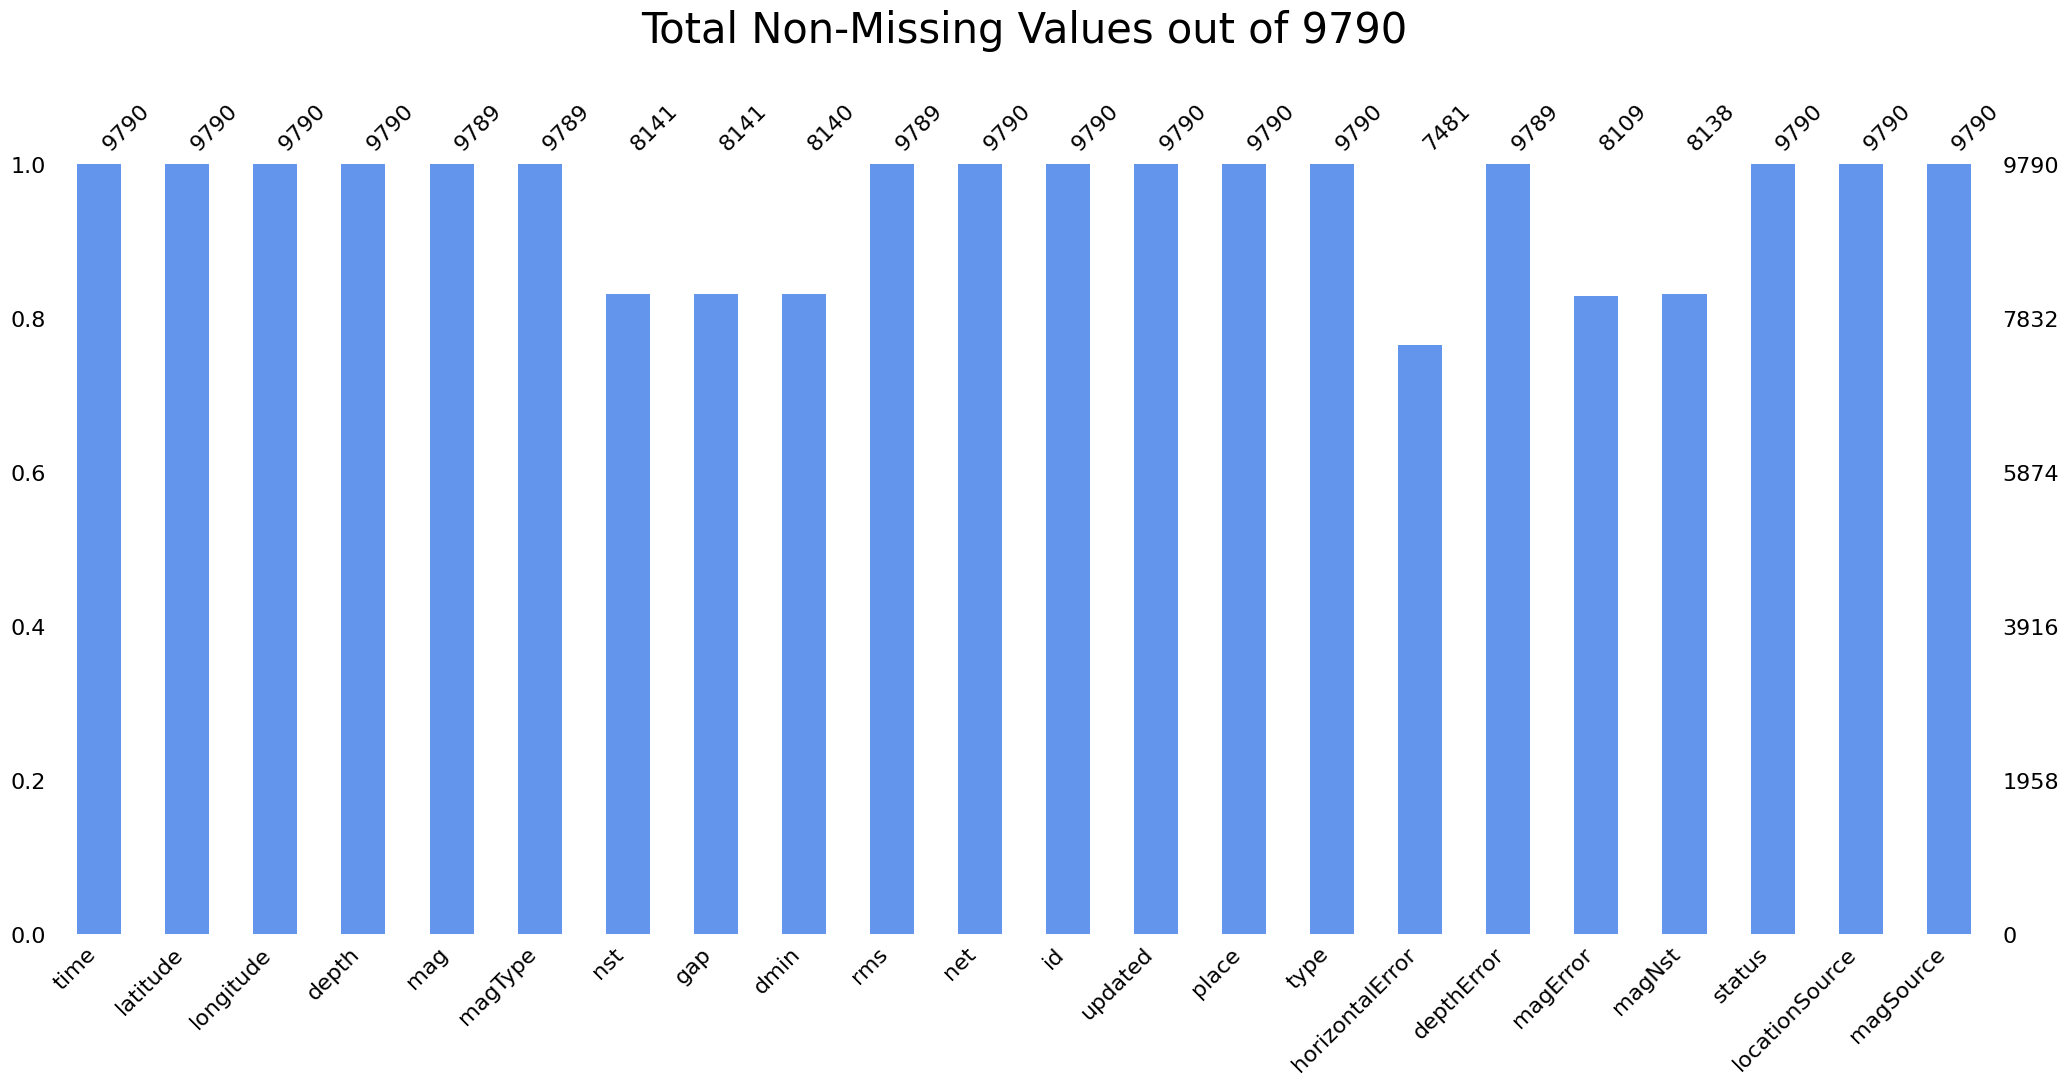

In [8]:
plt.title("Total Non-Missing Values out of 9790\n", fontsize=30)
msno.bar(df, color="cornflowerblue")

## Imputation

#### Mag & MagType

In [9]:
df.query('mag.isna()')

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
7304,2025-03-05T02:32:37.450Z,40.775333,-121.490833,17.18,NaN,NaN,7.0,152.0,0.04654,0.03,nc,nc75002953,2025-03-19T07:32:16.055Z,"19 km SE of Burney, CA",earthquake,1.19,1.75,NaN,NaN,reviewed,nc,nc


Looking at the only measurement that has a missing a missing magnitude, it appears to be a faulty reading by seismographs, therefore dropping this single would be more prudent than filling it with a an incorrect value.

In [10]:
df = df.dropna(subset=['mag']).reset_index(drop=True)

#### NST

In [11]:
df['nst'] = df.groupby('magType')['nst'].transform(lambda x: x.fillna(x.median()))

# Fallback for any other missing values
df['nst'] = df['nst'].fillna(df['nst'].median())

#### Gap

The azimuthal gap can be imputed using KNN based on location and magnitude, which will provide a more accurate filler.

In [12]:
gap_features = df[['latitude', 'longitude', 'depth', 'mag']].copy()
gap_missing = df['gap'].isna()

# Apply KNN imputation based on location
if gap_missing.sum() > 0:
    knn_imputer = KNNImputer(n_neighbors=5)
    gap_imputed = knn_imputer.fit_transform(
        pd.concat([gap_features, df[['gap']]], axis=1)
    )[:, -1]

    df.loc[gap_missing, 'gap'] = gap_imputed[gap_missing]

#### Dmin

Now to fill distance to nearest station based spatial relationship.

In [13]:
dmin_missing = df['dmin'].isna()
if dmin_missing.sum() > 0:
    dmin_features = df[['latitude', 'longitude', 'depth']].copy()
    knn_imputer = KNNImputer(n_neighbors=5)
    dmin_imputed = knn_imputer.fit_transform(
        pd.concat([dmin_features, df[['dmin']]], axis=1)
    )[:, -1]
    df.loc[dmin_missing, 'dmin'] = dmin_imputed[dmin_missing]

#### RMS

In [14]:
df['rms'] = df['rms'].fillna(df['rms'].median())

#### HorrizontalError

This feature likely has a non-linear relationship with the rest of the earthquake data. A random forest will be able to still capture the complex relationships while being robust to outliers.

In [15]:
hor_err_missing = df['horizontalError'].isna()

if hor_err_missing.sum() > 0:
    hor_err_features = df[['latitude', 'longitude', 'depth', 'mag', 'rms']].copy()

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(
        hor_err_features[~hor_err_missing],
        df.loc[~hor_err_missing, 'horizontalError']
    )

    df.loc[hor_err_missing, 'horizontalError'] = model.predict(
        hor_err_features[hor_err_missing]
    )

#### DepthError

In [16]:
df['depthError'] = df['depthError'].fillna(df['depthError'].median())

#### MagError

In [17]:
mag_err_missing = df['magError'].isna()

if mag_err_missing.sum() > 0:
    # Group by magType to find patterns
    df['magError'] = df.groupby('magType')['magError'].transform(
        lambda x: x.fillna(x.median())
    )

    df['magError'] = df['magError'].fillna(df['magError'].median())

#### MagNst

Fill magNst based on similar nst values.

In [18]:
df['magNst'] = df['magNst'].fillna(
    df['nst']
)

df['magNst'] = df.groupby('magType')['magNst'].transform(
    lambda x: x.fillna(x.median())
)

df['magNst'] = df['magNst'].fillna(df['magNst'].median())

Now to verify there are no more missing values.

In [19]:
df.isna().sum()

,0
time,0
latitude,0
longitude,0
depth,0
mag,0
magType,0
nst,0
gap,0
dmin,0
rms,0


## Duplicate Detection

In [20]:
def duplicates(df):
    before = df.shape[0]
    df = df.drop_duplicates()
    after = df.shape[0]

    total_duplicates = before - after
    print(f"There are a total of {total_duplicates} duplicates in this dataset.")

duplicates(df)

There are a total of 0 duplicates in this dataset.


## Outlier Detection

In [21]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000
mean,39.771101,-111.000748,20.691172,1.473695,21.581060,123.807409,0.375169,0.254157,2.137422,2.154550,0.177339,17.502809
std,18.148333,64.754601,53.829585,1.290200,20.287464,65.422590,1.392263,0.285555,4.327639,4.888849,0.097569,25.350770
min,-61.481300,-179.997100,-3.470000,-1.610000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.019000,-149.379200,2.340000,0.710000,10.000000,70.000000,0.015297,0.070000,0.296600,0.450000,0.122000,8.000000
50%,38.817833,-122.700668,6.860000,1.290000,15.000000,113.000000,0.059780,0.150000,0.570000,0.730000,0.179000,14.000000
75%,51.875167,-113.552000,14.500000,1.910000,24.000000,165.400000,0.163700,0.330000,2.770000,1.510000,0.203571,18.000000
max,85.684800,179.972400,646.456000,6.700000,267.000000,356.000000,39.426000,5.130000,183.633567,39.000000,2.490000,605.000000


Just looking at some of the values here, there are some red flags. Such as a negative value for magnitude, which would indicate an earthquake happening above the surface of the Earth, which is impossible.

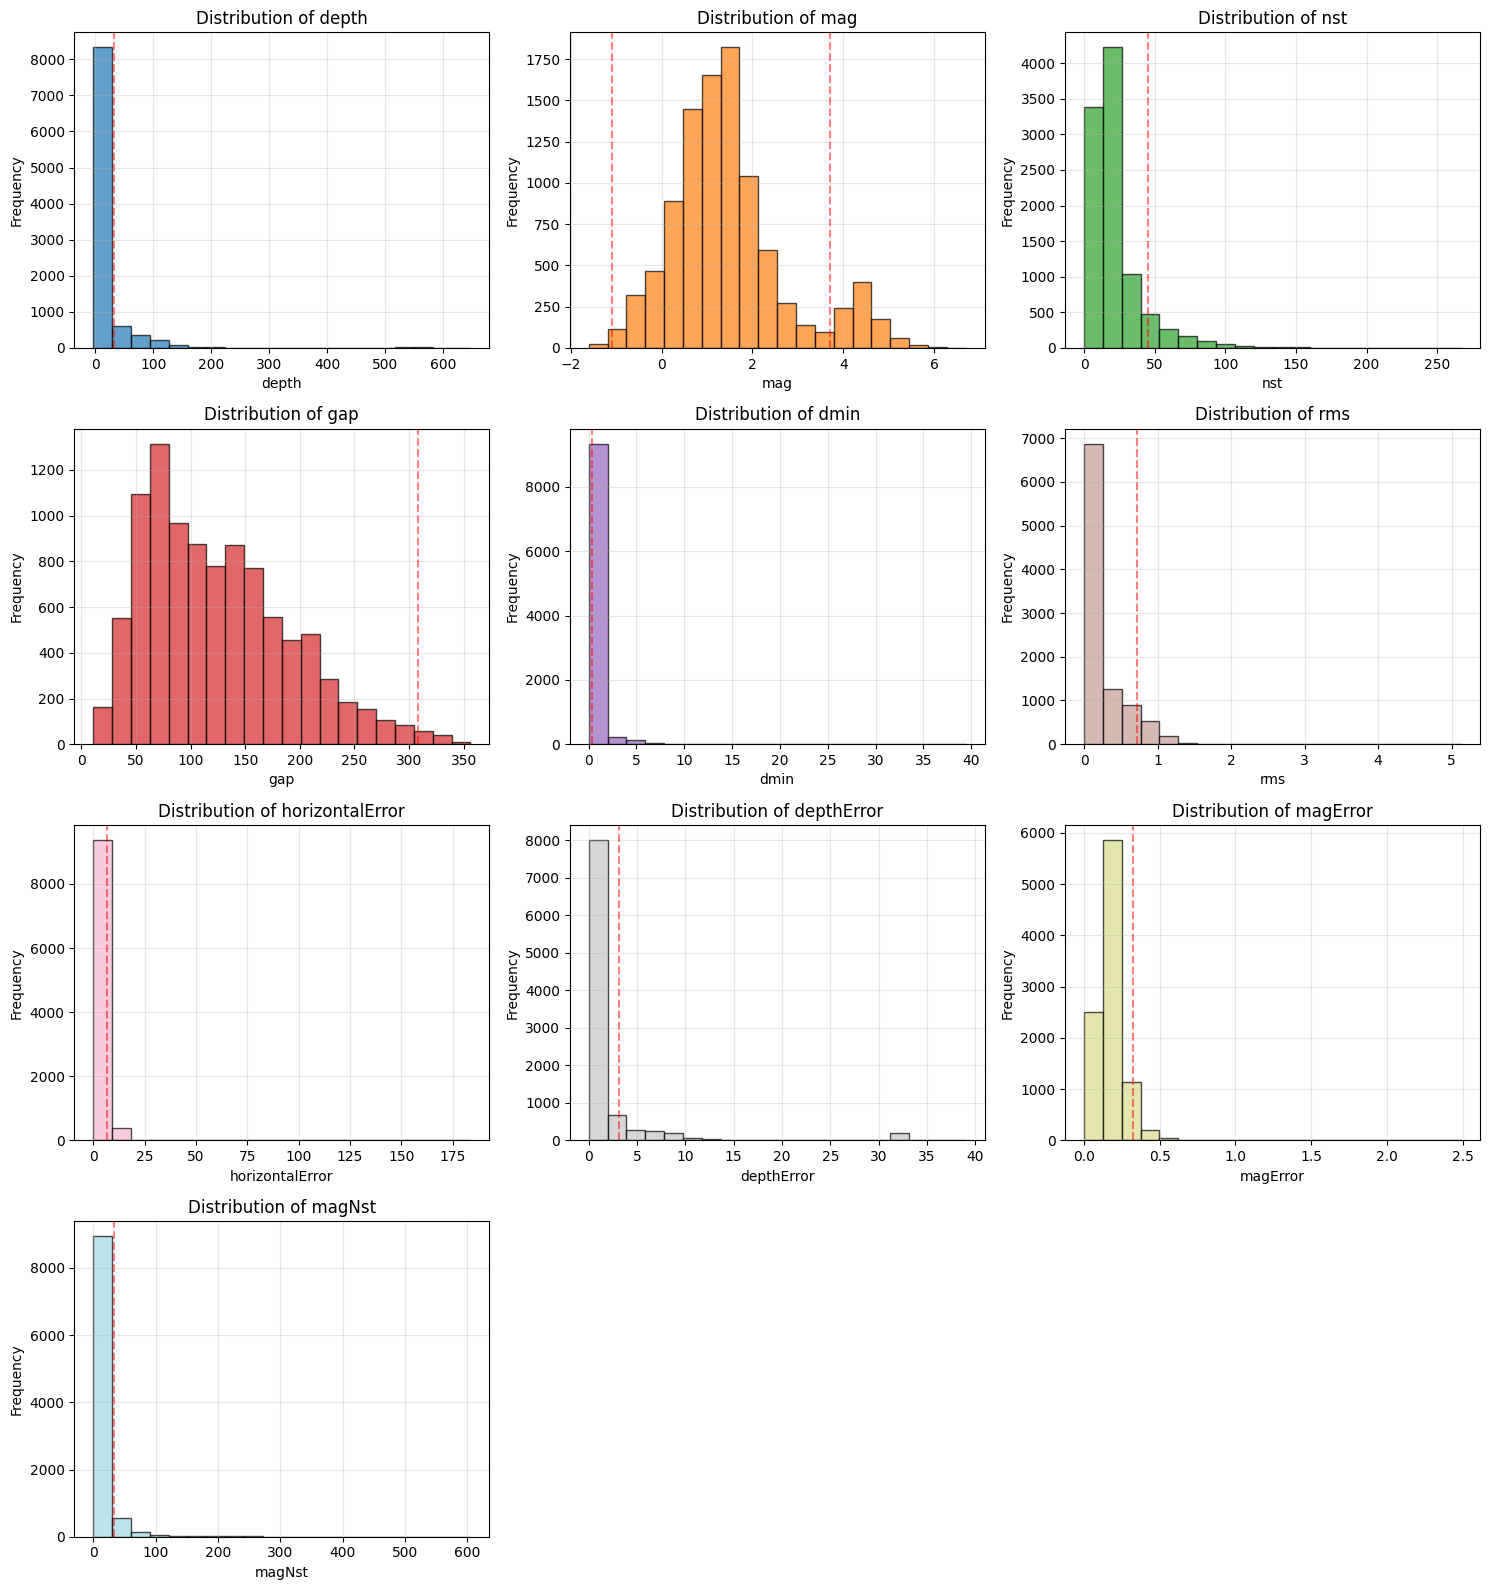

In [22]:
def plot_histograms(df):
    exclude_cols = ['time', 'place', 'type', 'status', 'locationSource', 'magSource',
                   'net', 'id', 'updated', 'magType', 'latitude', 'longitude']

    numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns
                   if col not in exclude_cols]

    n_cols = 3
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))

    plt.figure(figsize=(15, n_rows * 4))
    colors = plt.cm.tab20(np.linspace(0, 1, len(numeric_cols)))

    for i, column in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.hist(df[column].dropna(), bins=20, color=colors[i], alpha=0.7, edgecolor='black')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        if lower_bound > df[column].min():
            plt.axvline(x=lower_bound, color='r', linestyle='--', alpha=0.5)
        if upper_bound < df[column].max():
            plt.axvline(x=upper_bound, color='r', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_histograms(df)

## Z-Score Normalization

Definitely have so strong outliers here, best method to address this will be to apply some winsorization based z-scores. Any value that lies beyond the z-score threshold in either direction (positive or negaitve) is considered an outlier in the field of statistics.

**The Empirical Rule (68-95-99.7 Rule)**

For a normal distribution:
- About 68% of data falls within 1 standard deviation of the mean.
- About 95% of data falls within 2 standard deviations of the mean.
- About 99.7% of data falls within 3 standard deviations of the mean.

A z-score beyond ±3 means the data point lies in the 0.3% tail, making it highly unusual under the assumption of normality.

Note here that outliers are a problem when it come to machine learning as it can skew the model. However outliers are still important for raw analysis, particularly in EDA as outliers can provide insight into specific trends.

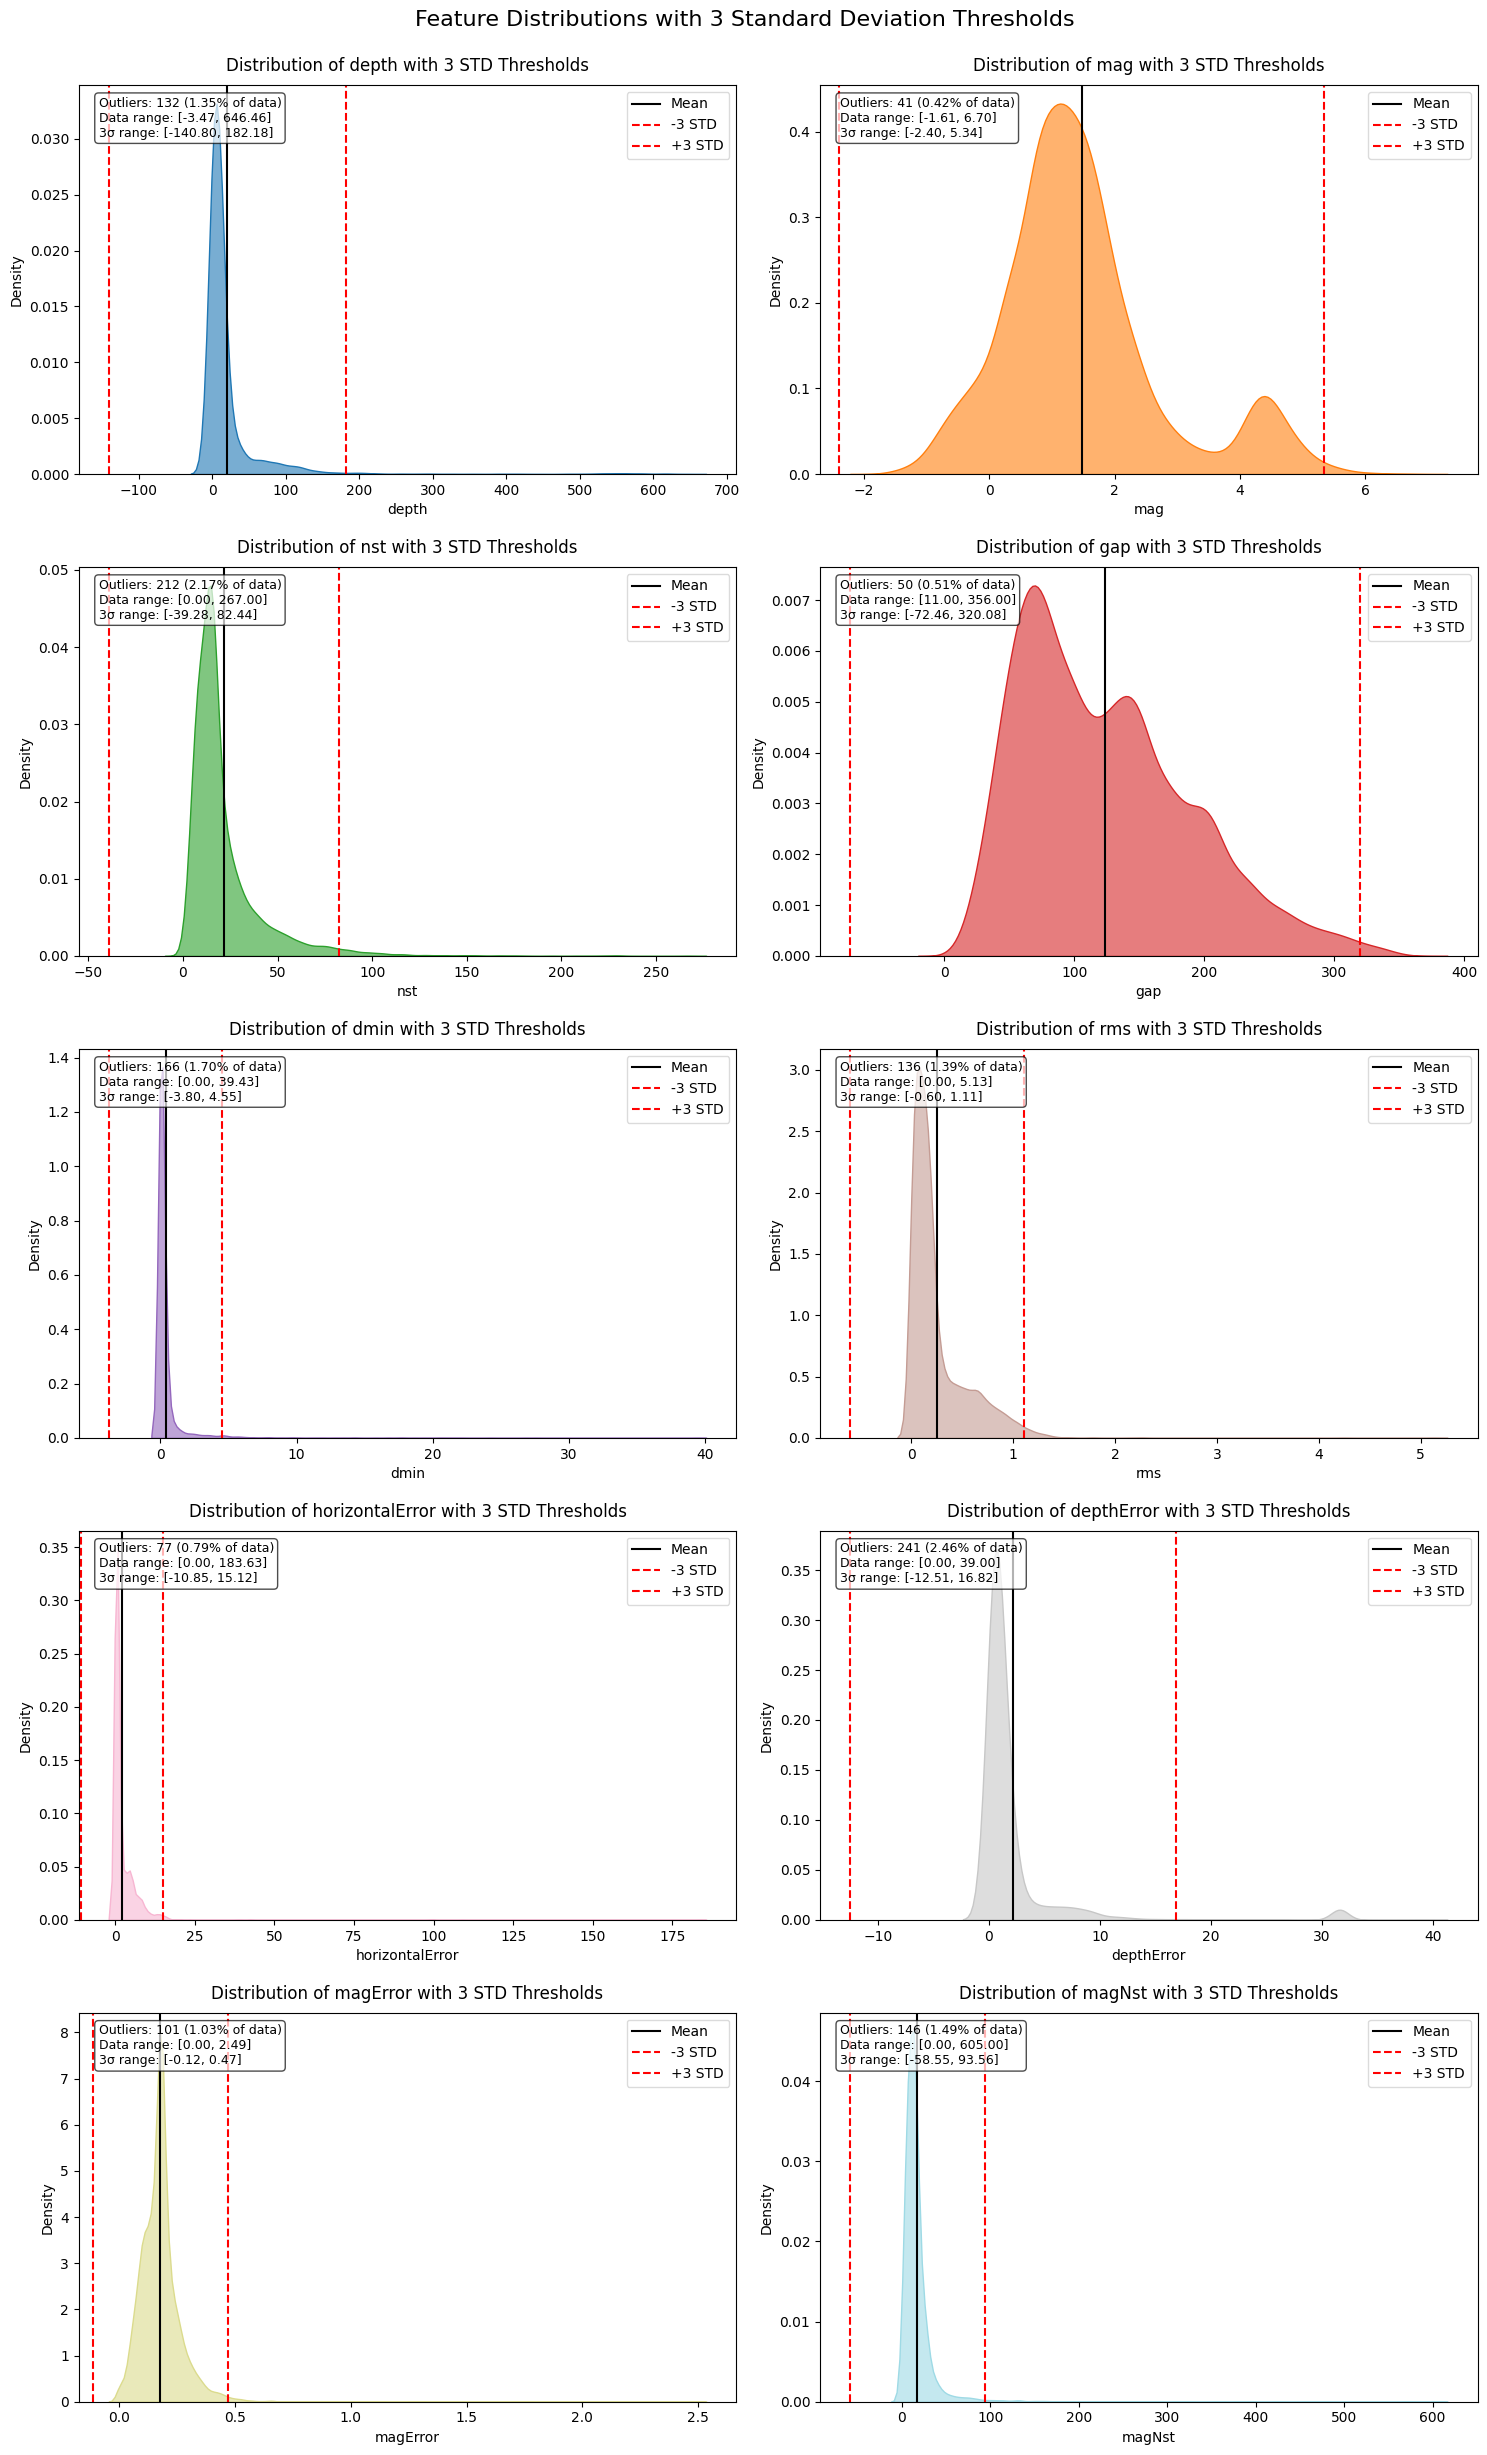

In [23]:
def plot_kde_with_thresholds(df):
    exclude_cols = ['time', 'place', 'type', 'status', 'locationSource', 'magSource',
                   'net', 'id', 'updated', 'magType', 'latitude', 'longitude']

    numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns
                   if col not in exclude_cols]

    n_cols = 2
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))

    plt.figure(figsize=(15, n_rows * 5))
    colors = plt.cm.tab20(np.linspace(0, 1, len(numeric_cols)))

    for i, column in enumerate(numeric_cols):
        ax = plt.subplot(n_rows, n_cols, i + 1)

        data = df[column].dropna()

        mean = data.mean()
        std = data.std()

        lower_threshold = mean - 3 * std
        upper_threshold = mean + 3 * std

        sns.kdeplot(data, fill=True, color=colors[i], alpha=0.6, ax=ax)

        plt.axvline(x=mean, color='black', linestyle='-', label='Mean')
        plt.axvline(x=lower_threshold, color='red', linestyle='--', label='-3 STD')
        plt.axvline(x=upper_threshold, color='red', linestyle='--', label='+3 STD')

        outliers_lower = data[data < lower_threshold]
        outliers_upper = data[data > upper_threshold]
        total_outliers = len(outliers_lower) + len(outliers_upper)
        outlier_pct = (total_outliers / len(data)) * 100

        plt.title(f'Distribution of {column} with 3 STD Thresholds', fontsize=12, pad=10)
        plt.xlabel(f'{column}', fontsize=10)
        plt.ylabel('Density', fontsize=10)

        plt.legend(loc='upper right', framealpha=0.7)

        textstr = f'Outliers: {total_outliers} ({outlier_pct:.2f}% of data)\n'
        textstr += f'Data range: [{data.min():.2f}, {data.max():.2f}]\n'
        textstr += f'3σ range: [{lower_threshold:.2f}, {upper_threshold:.2f}]'

        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        plt.text(0.03, 0.97, textstr, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)

    plt.tight_layout(h_pad=1.8)
    plt.subplots_adjust(top=0.95)
    plt.suptitle('Feature Distributions with 3 Standard Deviation Thresholds', fontsize=16)
    plt.show()

plot_kde_with_thresholds(df)

## Winsorization

Capping values at ±3 standard deviations from the mean.

In [24]:
from sklearn.preprocessing import StandardScaler

def winsorize_features(df, exclude_cols=None, std_threshold=3):
    if exclude_cols is None:
        exclude_cols = ['time', 'place', 'type', 'status', 'locationSource', 'magSource',
                       'net', 'id', 'updated', 'magType', 'latitude', 'longitude']

    numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns
                   if col not in exclude_cols]

    df_original = df.copy()
    df_scaled = df.copy()

    scalers = {}

    # Step 1: Scale the features
    for col in numeric_cols:
        scaler = StandardScaler()
        df_scaled[col] = scaler.fit_transform(df_scaled[[col]])
        scalers[col] = scaler

    # Step 2: Apply winsorization to the scaled features
    df_winsorized_scaled = df_scaled.copy()
    for col in numeric_cols:
        # Cap values at ±std_threshold (typically 3)
        df_winsorized_scaled[col] = df_winsorized_scaled[col].clip(
            lower=-std_threshold, upper=std_threshold
        )

    # Step 3: Transform back to original scale while preserving winsorization
    df_winsorized = df_winsorized_scaled.copy()
    for col in numeric_cols:
        df_winsorized[col] = scalers[col].inverse_transform(df_winsorized[[col]])

    return df_original, df_winsorized

df_original, df_cleaned = winsorize_features(df)

Now that the dataset has been cleaned, an original copy can still be used for any raw analysis such as any outliers that want to be investigated further.

In [25]:
df_original.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000
mean,39.771101,-111.000748,20.691172,1.473695,21.581060,123.807409,0.375169,0.254157,2.137422,2.154550,0.177339,17.502809
std,18.148333,64.754601,53.829585,1.290200,20.287464,65.422590,1.392263,0.285555,4.327639,4.888849,0.097569,25.350770
min,-61.481300,-179.997100,-3.470000,-1.610000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.019000,-149.379200,2.340000,0.710000,10.000000,70.000000,0.015297,0.070000,0.296600,0.450000,0.122000,8.000000
50%,38.817833,-122.700668,6.860000,1.290000,15.000000,113.000000,0.059780,0.150000,0.570000,0.730000,0.179000,14.000000
75%,51.875167,-113.552000,14.500000,1.910000,24.000000,165.400000,0.163700,0.330000,2.770000,1.510000,0.203571,18.000000
max,85.684800,179.972400,646.456000,6.700000,267.000000,356.000000,39.426000,5.130000,183.633567,39.000000,2.490000,605.000000


In [26]:
df_cleaned.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000
mean,39.771101,-111.000748,17.916456,1.472327,20.959583,123.746542,0.311032,0.251346,2.050924,1.837331,0.175048,16.303451
std,18.148333,64.754601,32.631785,1.285755,17.125600,65.231494,0.796384,0.270663,3.055093,3.155237,0.081353,15.111231
min,-61.481300,-179.997100,-3.470000,-1.610000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.019000,-149.379200,2.340000,0.710000,10.000000,70.000000,0.015297,0.070000,0.296600,0.450000,0.122000,8.000000
50%,38.817833,-122.700668,6.860000,1.290000,15.000000,113.000000,0.059780,0.150000,0.570000,0.730000,0.179000,14.000000
75%,51.875167,-113.552000,14.500000,1.910000,24.000000,165.400000,0.163700,0.330000,2.770000,1.510000,0.203571,18.000000
max,85.684800,179.972400,182.171680,5.344096,82.440345,320.065154,4.551744,1.110777,15.119675,16.820348,0.470031,93.551235


Now to address the problem of depth values below 0, indicating an earthquake above the surface. This is most likely due to instrumentation errors where it was expecting the epicenter to be at a specific location, or the trigonomety calculations were slightly off since our planet is not a perfect sphere. These values can simply be floored to 0 since surface earthquakes are actually quite common.

In [27]:
# Floor negative depth values to 0
df_cleaned['depth'] = df_cleaned['depth'].clip(lower=0)

print(f"Floored {(df['depth'] < 0).sum()} negative depth values to 0")

Floored 353 negative depth values to 0


In [28]:
df_cleaned.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000
mean,39.771101,-111.000748,17.958947,1.472327,20.959583,123.746542,0.311032,0.251346,2.050924,1.837331,0.175048,16.303451
std,18.148333,64.754601,32.607196,1.285755,17.125600,65.231494,0.796384,0.270663,3.055093,3.155237,0.081353,15.111231
min,-61.481300,-179.997100,0.000000,-1.610000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.019000,-149.379200,2.340000,0.710000,10.000000,70.000000,0.015297,0.070000,0.296600,0.450000,0.122000,8.000000
50%,38.817833,-122.700668,6.860000,1.290000,15.000000,113.000000,0.059780,0.150000,0.570000,0.730000,0.179000,14.000000
75%,51.875167,-113.552000,14.500000,1.910000,24.000000,165.400000,0.163700,0.330000,2.770000,1.510000,0.203571,18.000000
max,85.684800,179.972400,182.171680,5.344096,82.440345,320.065154,4.551744,1.110777,15.119675,16.820348,0.470031,93.551235


Also a magnitude that is below 0 might seem unintuitive, but it just represents magnitudes that are very small. For example a -1 on the richter scale is equivalent to dropping a heavy book on the floor.

Moving forward, use the df_cleaned for preprocessing and model training.

In [29]:
df_cleaned.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-03-28T01:59:29.748Z,37.154600,-117.414400,0.00,1.70,ml,12.0,129.5,0.16300,0.3882,nn,nn00895230,2025-03-28T02:06:35.591Z,"63 km SSW of Goldfield, Nevada",earthquake,2.049414,7.700,0.340000,7.0,automatic,nn,nn
1,2025-03-28T01:57:36.250Z,35.536835,-120.836334,7.20,1.90,md,20.0,72.0,0.09811,0.0300,nc,nc75156462,2025-03-28T01:59:11.162Z,"12 km NE of Cayucos, CA",earthquake,0.300000,0.890,0.140000,14.0,automatic,nc,nc
2,2025-03-28T01:53:57.153Z,-15.922100,167.894300,172.90,5.00,mb,48.0,142.0,0.81600,0.6500,us,us7000pn8t,2025-03-28T02:11:11.040Z,"54 km ENE of Lakatoro, Vanuatu",earthquake,10.150000,5.454,0.067000,71.0,reviewed,us,us
3,2025-03-28T01:41:18.660Z,38.819000,-122.766670,1.66,1.45,md,12.0,106.0,0.01173,0.0200,nc,nc75156457,2025-03-28T01:42:56.113Z,"4 km W of Cobb, CA",earthquake,0.290000,0.480,0.190000,14.0,automatic,nc,nc
4,2025-03-28T01:22:38.780Z,17.955333,-66.832167,13.71,2.17,md,7.0,208.0,0.04893,0.1100,pr,pr71477703,2025-03-28T01:32:39.220Z,"4 km SSW of Indios, Puerto Rico",earthquake,0.790000,0.340,0.141908,6.0,reviewed,pr,pr


# Data Science

### Feature Engineering to add columns for further analysis.



In [30]:
# Convert 'time' to datetime format (if not already done)
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'])

# Extract the hour for Time of Day analysis
df_cleaned['hour'] = df_cleaned['time'].dt.hour

# Extract the day of the week for Day of the Week analysis
df_cleaned['day_of_week'] = df_cleaned['time'].dt.day_name()

# Check the extracted columns
print(df_cleaned[['time', 'hour', 'day_of_week']].head())



                              time  hour day_of_week
0 2025-03-28 01:59:29.748000+00:00     1      Friday
1 2025-03-28 01:57:36.250000+00:00     1      Friday
2 2025-03-28 01:53:57.153000+00:00     1      Friday
3 2025-03-28 01:41:18.660000+00:00     1      Friday
4 2025-03-28 01:22:38.780000+00:00     1      Friday


## Summary *Statistics*

In [31]:
# Basic descriptive statistics
df_cleaned.describe().T

# Check the distribution of categorical features

categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_cols].nunique()

,0
magType,9
net,15
id,9789
updated,9788
place,5103
type,5
status,2
locationSource,15
magSource,15
day_of_week,7


## Correlation matrix with heatmap

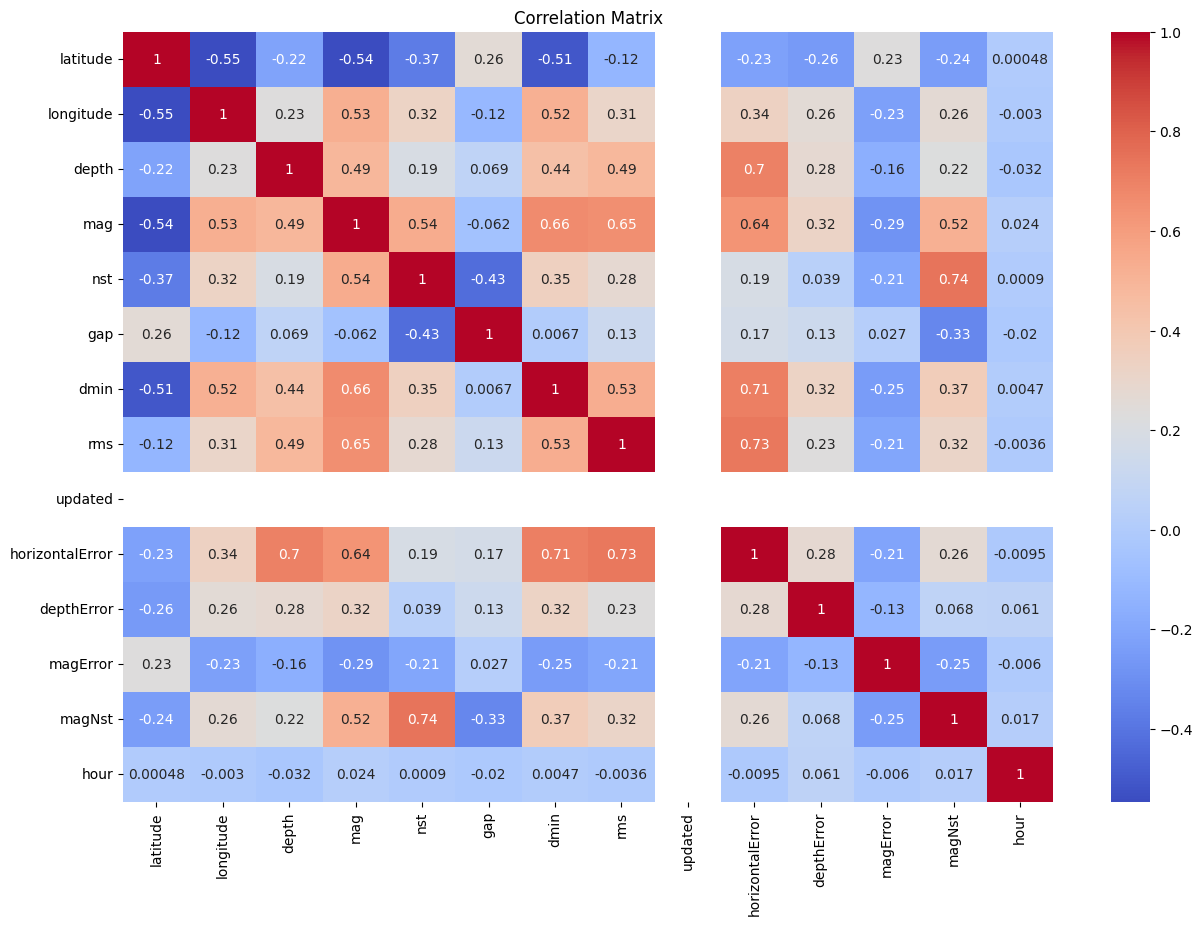

In [32]:
# Convert 'time' and 'updated' to numeric using to_numeric with errors='coerce'
for col in ['time', 'updated']:
    if df_cleaned[col].dtype == 'object':  # Check if it's an object (string) type
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Select only numeric columns for correlation calculation
numeric_df = df_cleaned.select_dtypes(include=['number'])

plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Observations of Correlation Matrix

## Positive Correlations (Closer to +1):

1.   magnst and nst (0.74): A strong positive relationship. This suggests that as the number of reporting stations () increases, the number of stations used for magnitude calculation () also increases, which makes sense from a data collection perspective.
2.   horizontalError and dmin (0.71): Indicates that as the horizontal error increases, the minimum distance to the event also tends to increase.
3. depth and horizontalError (0.71): Suggests that earthquakes occurring at greater depths are more likely to have higher horizontal errors in their recorded locations.

## Moderate Positive Correlations:

1.  mag and depth (0.66): Indicates that deeper earthquakes tend to have slightly higher magnitudes.
2.  mag and rms (0.65): Suggests that earthquakes with higher magnitudes may also have higher root mean square error in their recorded seismic waves.

## Distribution for numeric features

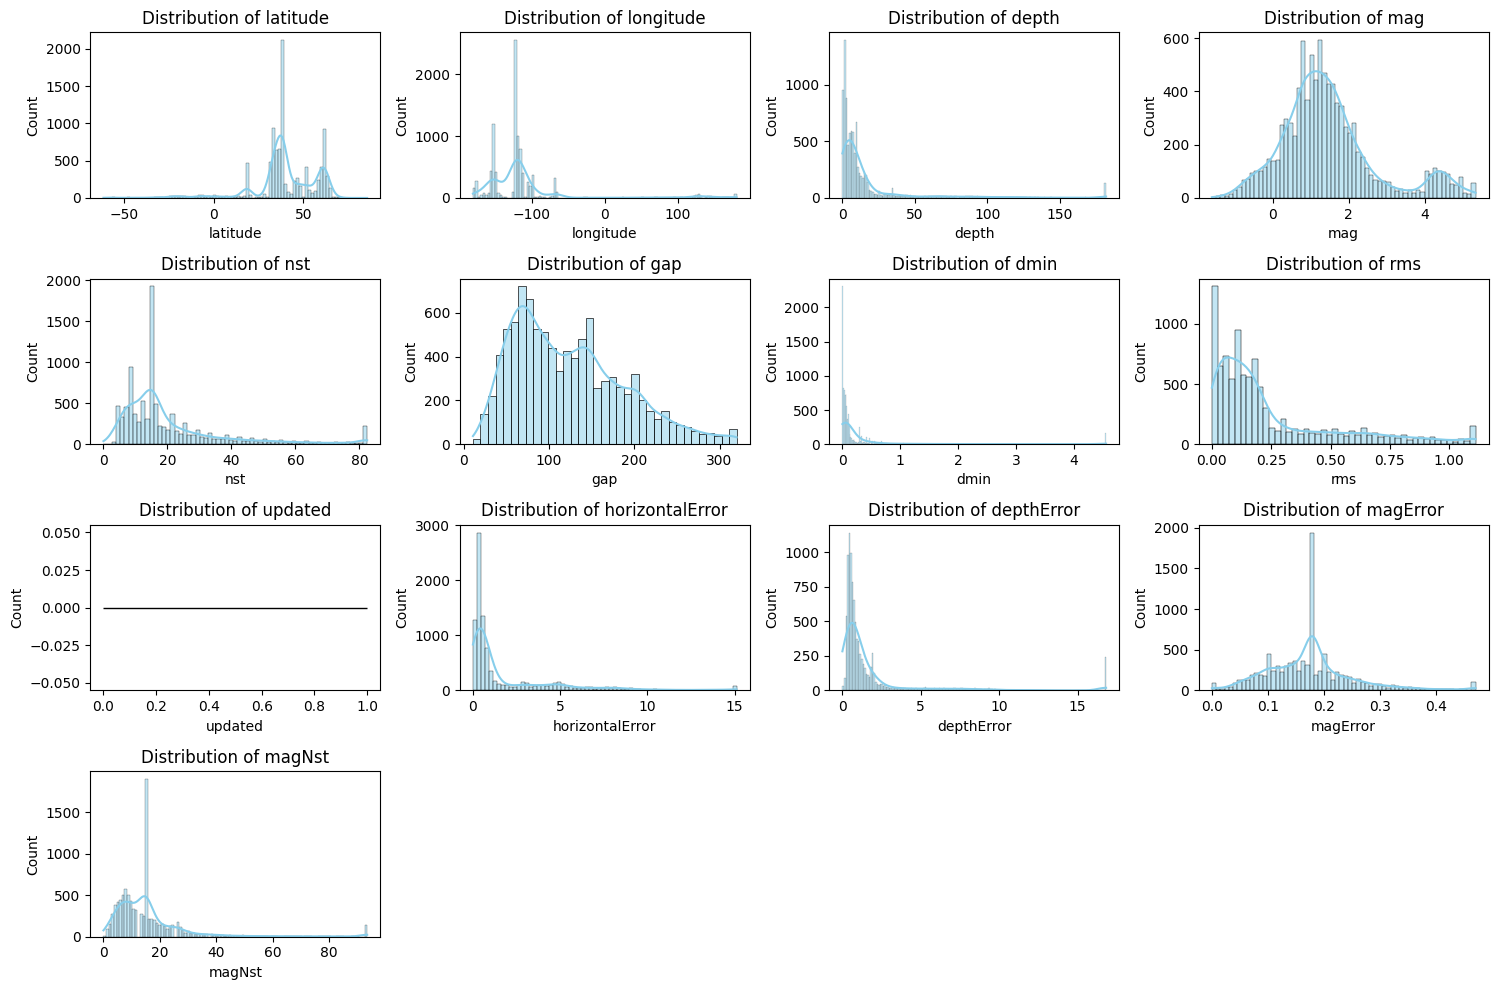

In [33]:
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df_cleaned[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


# Observations of numeric features distribution

### Depth (Significantly left skewed):

1.   The majority of earthquakes falls heavily on the lower side, with the majority falling near 0.

### Magnitude (Right skewed):

1.  Magnitude is slightly right skewed, with a gradual incline before peaking around 2. Possible outliers may skew the data slightly, but data falls within expectations.

### Gap (Left skewed):

1. Azimuthal gap is skewed to the left, but the slope is very gradual with occassional peaks throughout.

## Key Relationships Visualizations - Mag vs Depth



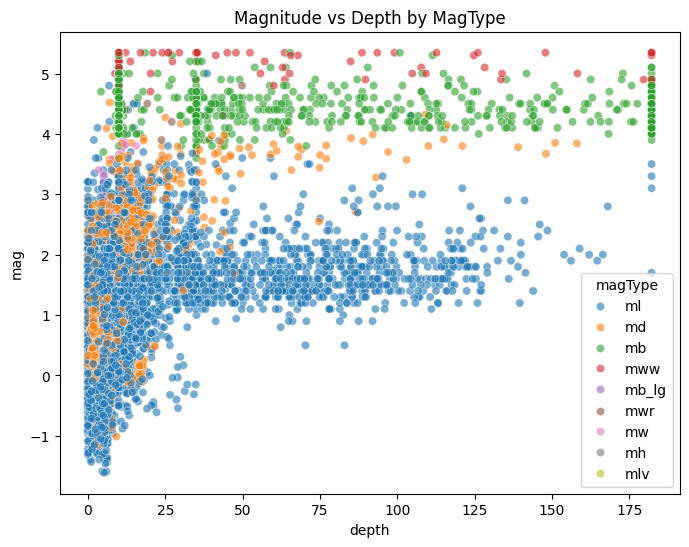

In [34]:
# Key Relationships Visualizations - Mag vs Depth

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cleaned, x='depth', y='mag', hue='magType', alpha=0.6)
plt.title('Magnitude vs Depth by MagType')
plt.show()



## Observations of Mag v Depth

### Clustering of Points:

1.   There's a clear concentration of earthquakes with lower magnitudes (mag < 2) at shallower depths (depth < 50 km).
2.   This clustering suggests that shallow earthquakes are generally less intense, which aligns with typical geological patterns.

### Distribution of Higher Magnitude Earthquakes:
1. Higher magnitudes (mag > 4) are observed across a broader range of depths.
2. These events could be linked to deeper fault lines or subduction zones where tectonic plates interact more intensely.

### Differences by MagType:
The different colors/markers for  suggest some variation in how magnitude is determined:
  1. Certain  like  (local magnitude) dominate in lower-magnitude events.
  2. Types like  (moment magnitude) appear more often in higher-magnitude or deeper events, indicating it might be better suited for these cases.



## Magnitude Distribution by Type

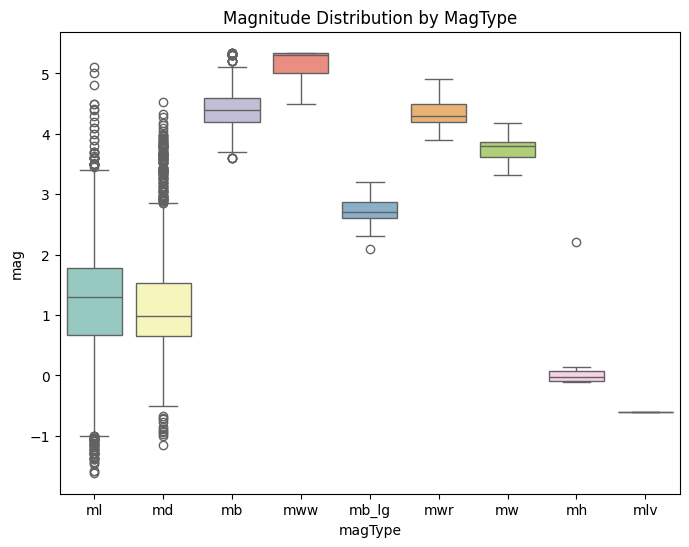

In [35]:
# Mag Distribution by Type

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_cleaned, x='magType', y='mag', palette='Set3')
plt.title('Magnitude Distribution by MagType')
plt.show()


## Observations of Distribution by Type

### Median Magnitudes
1. Types like  and  have higher median magnitudes compared to others like  and , indicating that certain types may be more common for stronger earthquakes.

### Magnitude Spread
1. The height of each box shows the interquartile range (IQR), which indicates the spread of the middle 50% of magnitudes for a given magType.
2. Narrower boxes (e.g., mb_lg and ml) suggest less variation in recorded magnitudes, while wider boxes (e.g., mw) indicate greater variability.

### Outliers
1. Dots beyond the whiskers represent outliers—values that are significantly higher or lower than the rest.
2. For instance, outliers at higher magnitudes within  might signify rare but intense earthquakes recorded using this method.

### MagType Differences
1.  Some magTypes like mww and mw show a broader range, which may reflect their suitability for analyzing larger and more complex seismic events.
2.  Types like ml (local magnitude) and md (duration magnitude) are limited to smaller magnitudes, which is consistent with their use for local seismic activity.

## Earthquake by Hour of the Day

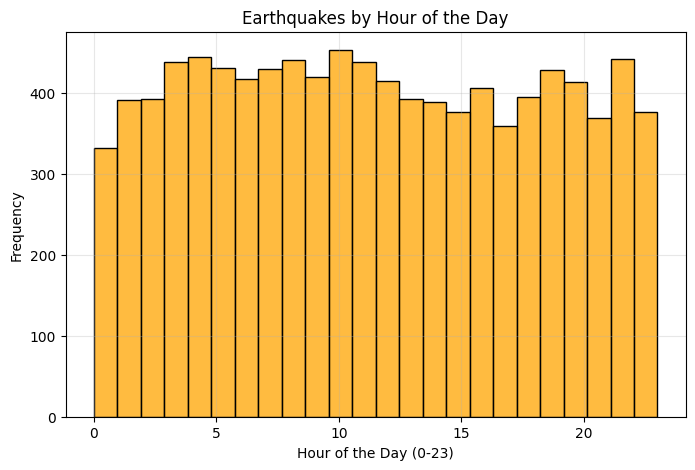

In [36]:
# Extract hour from the 'time' column
df_cleaned['hour'] = df_cleaned['time'].dt.hour

# Plot the distribution of earthquakes by hour
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['hour'], bins=24, kde=False, color='orange')
plt.title('Earthquakes by Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()



## Observations of Earthquakes by Hour

### Distribution
1. Fairly balanced. This suggests the hour of the day does not have significant impact on whether an earthquake will occur.

## Earthquakes by Day of the Week

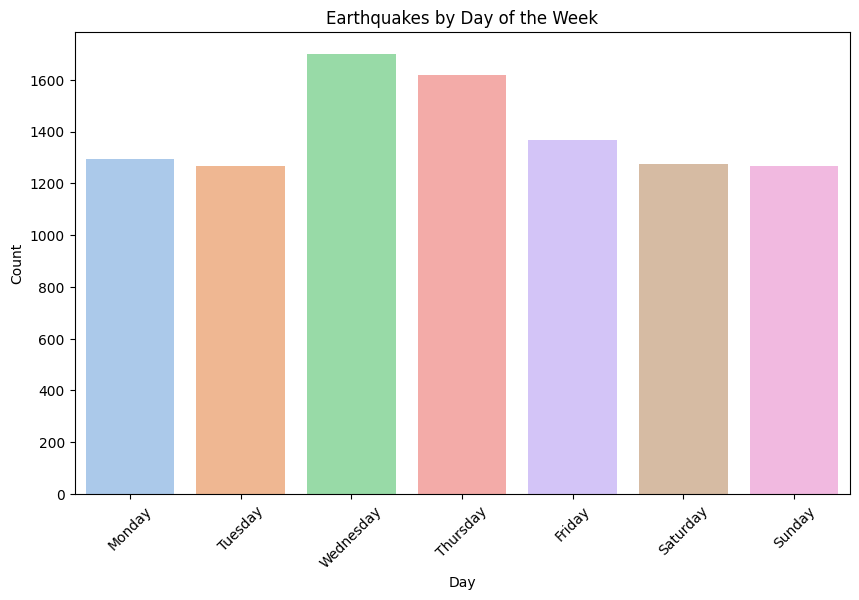

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='day_of_week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='pastel')
plt.title('Earthquakes by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



## Observations of Earthquakes by Day

### Distribution
1. Similarly to hourly correlation, day of the week does not appear to impact earthquakes occuring significantly, however there is a significant increase between Tuesday and Wednesday, which may suggest some kind of influence.

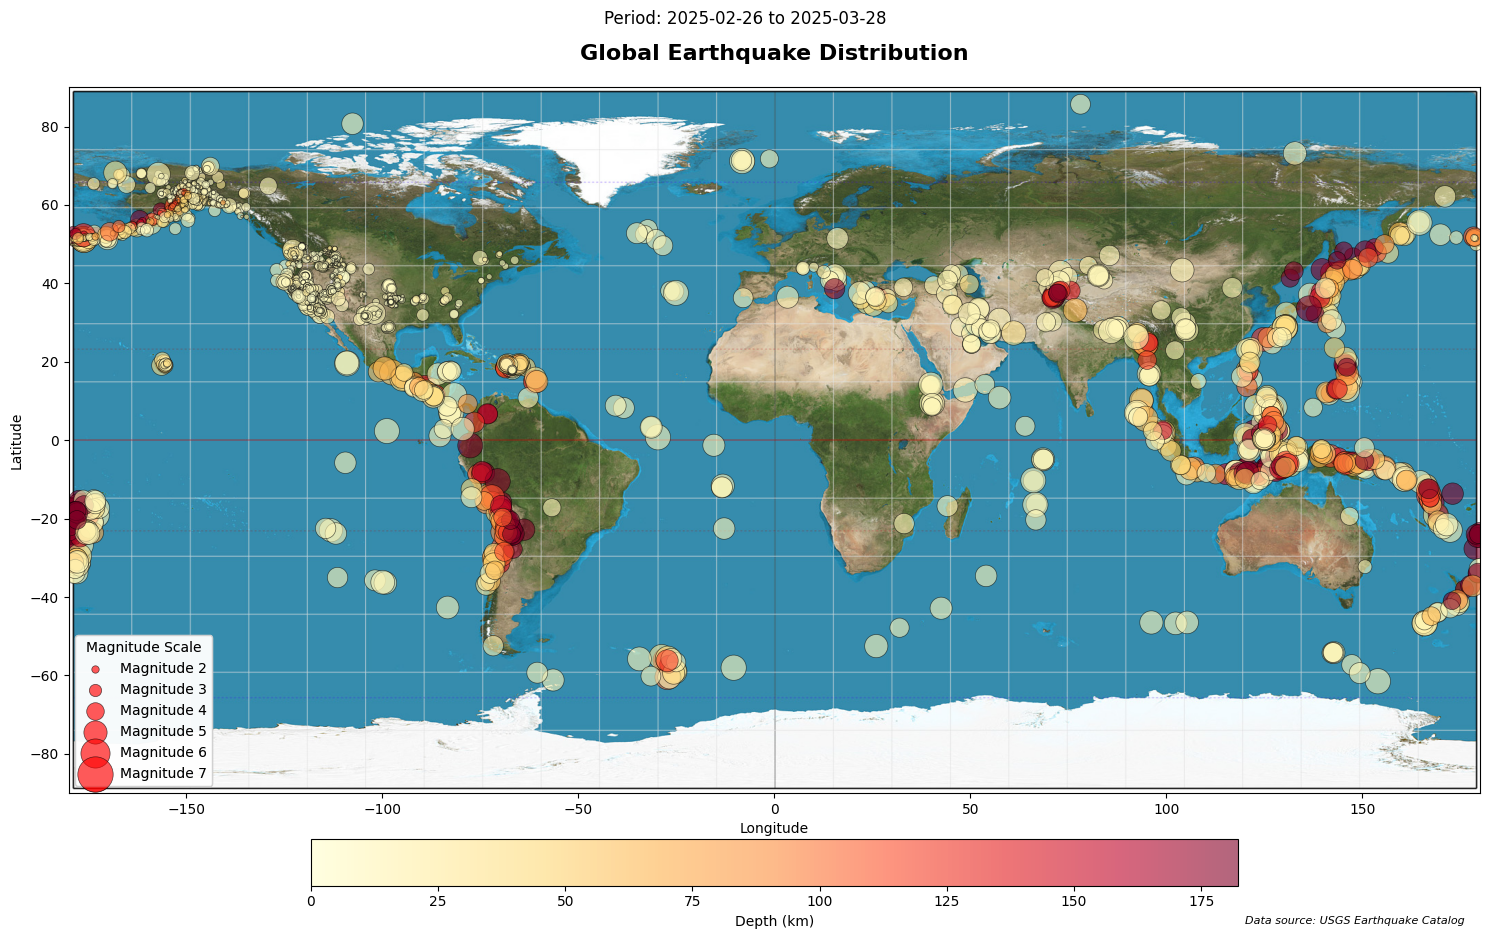

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize

plt.figure(figsize=(15, 10))

from urllib.request import urlretrieve
import matplotlib.image as mpimg

map_img_url = 'https://upload.wikimedia.org/wikipedia/commons/8/83/Equirectangular_projection_SW.jpg'
map_img_file = 'world_map.jpg'
try:
    urlretrieve(map_img_url, map_img_file)
    img = mpimg.imread(map_img_file)
    plt.imshow(img, extent=[-180, 180, -90, 90])
except:
    # If download fails, create a very basic continents outline
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    for lat in range(-90, 91, 30):
        plt.axhline(y=lat, color='gray', linestyle='--', alpha=0.3)
    for lon in range(-180, 181, 30):
        plt.axvline(x=lon, color='gray', linestyle='--', alpha=0.3)

cmap = plt.cm.YlOrRd
norm = Normalize(vmin=df_cleaned['depth'].min(), vmax=df_cleaned['depth'].max())

scatter = plt.scatter(
    df_cleaned['longitude'],
    df_cleaned['latitude'],
    s=df_cleaned['mag'] ** 2.5 * 5,
    c=df_cleaned['depth'],
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)
plt.title('Global Earthquake Distribution', fontsize=16, fontweight='bold', pad=20)
max_date = pd.to_datetime(df_cleaned['time']).max().strftime('%Y-%m-%d')
min_date = pd.to_datetime(df_cleaned['time']).min().strftime('%Y-%m-%d')
plt.figtext(0.5, 0.92, f'Period: {min_date} to {max_date}', ha='center', fontsize=12)

handles = []
labels = []
sizes = [2, 3, 4, 5, 6, 7]
for mag in sizes:
    size = mag ** 2.5 * 5
    handle = plt.scatter([], [], s=size, color='red',
                      edgecolor='black', linewidth=0.5, alpha=0.6)
    handles.append(handle)
    labels.append(f'Magnitude {mag}')

legend1 = plt.legend(handles, labels, title='Magnitude Scale', loc='lower left', frameon=True, framealpha=0.8)
plt.gca().add_artist(legend1)
cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.05, fraction=0.05)
cbar.set_label('Depth (km)', fontsize=10)
plt.figtext(0.98, 0.02, 'Data source: USGS Earthquake Catalog', ha='right', fontsize=8, fontstyle='italic')
plt.tight_layout()
plt.show()